In [1]:
import numpy as np
import re
import numpy as np
import pandas as pd
global alphabet
global maxlen
global N_LANG
N_LANG=10
maxlen=13 #max word lenght 13
alphabet = "abcdefghijklmnopqrstuvwxyzíóéáñúüäßöàèêçôùîûâìòźåãõíłęążśćńøæ" #61 different character found in 10 European different Language
def one_hot_encode(data):
  char_to_int = dict((c, i) for i, c in enumerate(alphabet))
  integer_encoded = [char_to_int[char] for char in data]
  onehot_encoded = []
  for value in integer_encoded:
    letter = np.zeros(len(alphabet))
    letter[value] = 1
    onehot_encoded.append(letter)
  while(len(onehot_encoded)<maxlen):
    letter = np.zeros(len(alphabet))
    onehot_encoded.append(letter)
  return  np.array(onehot_encoded)

def encode_labels(label):
  temp = np.zeros(N_LANG)
  temp[label-1] = 1
  return temp

def process(test_str):
  test_str=test_str.lower()
  test_str = re.sub(r'[^a-zA-Z ]', '', test_str)
  return test_str

In [2]:
x=[]
y=[]
df=pd.read_csv('https://github.com/404S-retr0/HPE_Project_Grp-8/blob/main/Data_Wordlists.csv?raw=true')
for word,lang in zip(df.WORDS,df.LANGAUAGE_VECTOR):
    if(pd.isna(word)):
      continue
    if(len(word)<=maxlen):
      x.append(one_hot_encode(process(word)))
      y.append(encode_labels(int(lang)))
x=np.array(x)
print(x.shape)
y=np.array(y)
print(y.shape)

(905779, 13, 61)
(905779, 10)


In [33]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard

In [41]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.5)
network = Sequential()
network.add(Flatten())
network.add(Dense(200, input_dim=61*maxlen, activation='sigmoid'))
network.add(Dense(150, activation='sigmoid'))
network.add(Dense(100, activation='sigmoid'))
network.add(Dense(50, activation='sigmoid'))
network.add(Dense(N_LANG, activation='softmax'))
network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
from keras.callbacks import EarlyStopping
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tboard = TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
callbacks_list = [checkpoint, tboard]
history=network.fit(x_train,y_train, epochs=40, batch_size=500, validation_data=(x_test,y_test),callbacks=callbacks_list,verbose=1)

Train on 452889 samples, validate on 452890 samples
Epoch 1/40
452889/452889 [==============================] - 8s 19us/step - loss: 0.2957 - accuracy: 0.9028 - val_loss: 0.2787 - val_accuracy: 0.9043
Epoch 2/40
452889/452889 [==============================] - 8s 17us/step - loss: 0.2740 - accuracy: 0.9048 - val_loss: 0.2695 - val_accuracy: 0.9051
Epoch 3/40
452889/452889 [==============================] - 8s 18us/step - loss: 0.2672 - accuracy: 0.9055 - val_loss: 0.2640 - val_accuracy: 0.9062
Epoch 4/40
452889/452889 [==============================] - 8s 18us/step - loss: 0.2622 - accuracy: 0.9065 - val_loss: 0.2610 - val_accuracy: 0.9068
Epoch 5/40
452889/452889 [==============================] - 8s 17us/step - loss: 0.2595 - accuracy: 0.9072 - val_loss: 0.2584 - val_accuracy: 0.9076

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


In [43]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

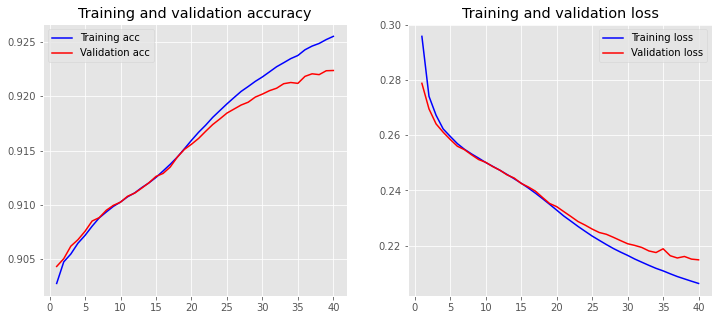

In [44]:
plot_history(history)

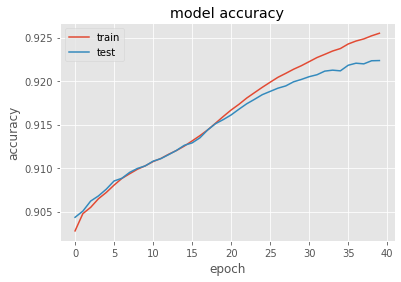

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
def text2list(text):
  import string
  import re
  test_str=text
  test_str = ''.join([i for i in test_str if not i.isdigit()]) 
  test_str=test_str.lower()
  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~+-=|`'''

  for ele in test_str:
    if ele in punc:
      test_str = test_str.replace(ele, "")  

  test_str_split=re.split('\s+', test_str)
  
  if (test_str_split[0]==''):
    test_str_split.remove('')
  if (test_str_split[len(test_str_split)-1]==''):
    test_str_split.remove('')

  return test_str_split

In [47]:
def lang_detect(text):
    list_of_word=text2list(text)
    k=[]
    for word in list_of_word:
        k.append(one_hot_encode(process(word)))
        ans=network.predict(np.array(k))
    print('Predication of language belonging of each unique word from a sentence\n')
    eng=0
    dan=0
    dut=0
    fre=0
    ger=0
    ita=0
    pol=0
    por=0
    spa=0
    swe=0
    for q in range(len(list_of_word)):
        eng+=ans[q][0]
        dan+=ans[q][0]
        dut=ans[q][0]
        fre+=ans[q][0]
        ger+=ans[q][0]
        ita+=ans[q][0]
        pol+=ans[q][0]
        por+=ans[q][0]
        spa+=ans[q][0]
        swe+=ans[q][0]
        each_word=list_of_word[q]
        print(each_word)
        report = "Percentage Distribution\nEnglish:-{}\nDanish:-{}\nDutch:-{}\nFrench:-{}\nGerman:-{}\nItalian:-{}\nPolish:-{}\nPortuguese:-{}\nSpanish:-{}\nSwedish:-{}\n".format(eng,dan,dut,fre,ger,ita,pol,por,spa,swe)
        print(report)

In [48]:
lang_detect('freshdire')

Predication of language belonging of each unique word from a sentence

freshdirect
Percentage Distribution
English:-0.34213757514953613
Danish:-0.34213757514953613
Dutch:-0.34213757514953613
French:-0.34213757514953613
German:-0.34213757514953613
Italian:-0.34213757514953613
Polish:-0.34213757514953613
Portuguese:-0.34213757514953613
Spanish:-0.34213757514953613
Swedish:-0.34213757514953613

